In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import torch
from torchvision import datasets, transforms, models  # datsets  , transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn as nn
import torch.nn.functional as F
from datetime import datetime

c:\Users\POLU RAKESH\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
transform = transforms.Compose(
    [transforms.Resize(255), transforms.CenterCrop(224), transforms.ToTensor()]
)

In [4]:
dataset = datasets.ImageFolder("../Project/Plant_leave_diseases_dataset_with_augmentation", transform=transform)

In [5]:
dataset

Dataset ImageFolder
    Number of datapoints: 340
    Root location: ../Project/Plant_leave_diseases_dataset_with_augmentation
    StandardTransform
Transform: Compose(
               Resize(size=255, interpolation=bilinear)
               CenterCrop(size=(224, 224))
               ToTensor()
           )

In [6]:
indices = list(range(len(dataset)))
print(len(indices))

340


In [7]:
split = int(np.floor(0.85 * len(dataset)))  # train_size
print(split)

289


In [8]:
validation = int(np.floor(0.70 * split))  # validation
print(validation)

202


In [9]:
print(0, validation, split, len(dataset))

0 202 289 340


In [10]:
print(f"length of train size :{validation}")
print(f"length of validation size :{split - validation}")
print(f"length of test size :{len(dataset)-validation}")

length of train size :202
length of validation size :87
length of test size :138


In [11]:
np.random.shuffle(indices)

In [12]:
train_indices, validation_indices, test_indices = (
    indices[:validation],
    indices[validation:split],
    indices[split:],
)

In [13]:
train_sampler = SubsetRandomSampler(train_indices)
validation_sampler = SubsetRandomSampler(validation_indices)
test_sampler = SubsetRandomSampler(test_indices)

In [14]:
targets_size = len(dataset.class_to_idx)

In [15]:
class CNN(nn.Module):
    def __init__(self, K):
        super(CNN, self).__init__()
        self.conv_layers = nn.Sequential(
            # conv1
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2),
            # conv2
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2),
            # conv3
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2),
            # conv4
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(2),
        )

        self.dense_layers = nn.Sequential(
            nn.Dropout(0.4),
            nn.Linear(50176, 1024),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(1024, K),
        )

    def forward(self, X):
        out = self.conv_layers(X)

        # Flatten
        out = out.view(-1, 50176)

        # Fully connected
        out = self.dense_layers(out)

        return out

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [17]:
device = "cpu"

In [18]:
model = CNN(targets_size)

In [19]:
model.to(device)

CNN(
  (conv_layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)

In [20]:
from torchsummary import summary

summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 224, 224]             896
              ReLU-2         [-1, 32, 224, 224]               0
       BatchNorm2d-3         [-1, 32, 224, 224]              64
            Conv2d-4         [-1, 32, 224, 224]           9,248
              ReLU-5         [-1, 32, 224, 224]               0
       BatchNorm2d-6         [-1, 32, 224, 224]              64
         MaxPool2d-7         [-1, 32, 112, 112]               0
            Conv2d-8         [-1, 64, 112, 112]          18,496
              ReLU-9         [-1, 64, 112, 112]               0
      BatchNorm2d-10         [-1, 64, 112, 112]             128
           Conv2d-11         [-1, 64, 112, 112]          36,928
             ReLU-12         [-1, 64, 112, 112]               0
      BatchNorm2d-13         [-1, 64, 112, 112]             128
        MaxPool2d-14           [-1, 64,

In [21]:
criterion = nn.CrossEntropyLoss()  # this include softmax + cross entropy loss
optimizer = torch.optim.Adam(model.parameters())

In [22]:
def batch_gd(model, criterion, train_loader, validation_loader, epochs):
    train_losses = np.zeros(epochs)
    test_losses = np.zeros(epochs)
    validation_losses = np.zeros(epochs)
    for e in range(epochs):
        t0 = datetime.now()
        train_loss = []
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()

            output = model(inputs)

            loss = criterion(output, targets)

            train_loss.append(loss.item())  # torch to numpy world

            loss.backward()
            optimizer.step()

        train_loss = np.mean(train_loss)

        validation_loss = []

        for inputs, targets in validation_loader:

            inputs, targets = inputs.to(device), targets.to(device)

            output = model(inputs)

            loss = criterion(output, targets)

            validation_loss.append(loss.item())  # torch to numpy world

        validation_loss = np.mean(validation_loss)

        train_losses[e] = train_loss
        validation_losses[e] = validation_loss

        dt = datetime.now() - t0

        print(
            f"Epoch : {e+1}/{epochs} Train_loss:{train_loss:.3f} Test_loss:{validation_loss:.3f} Duration:{dt}"
        )

    return train_losses, validation_losses

In [23]:
device = "cpu"

In [24]:
batch_size = 64
train_loader = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size, sampler=train_sampler
)
test_loader = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size, sampler=test_sampler
)
validation_loader = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size, sampler=validation_sampler
)

In [25]:
train_losses, validation_losses = batch_gd(
    model, criterion, train_loader, validation_loader, 3
)

Epoch : 1/3 Train_loss:12.193 Test_loss:9.453 Duration:0:01:53.215860
Epoch : 2/3 Train_loss:8.238 Test_loss:7.979 Duration:0:02:15.665121
Epoch : 3/3 Train_loss:3.996 Test_loss:11.726 Duration:0:02:06.781758


In [26]:
torch.save(model.state_dict() , '../Project/plant_disease_model.pt')

In [27]:
targets_size = 39
model = CNN(targets_size)
model.load_state_dict(torch.load("../Project/plant_disease_modell.pt"))
model.eval()

CNN(
  (conv_layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)

In [28]:
# %matplotlib notebook

### Plot the loss

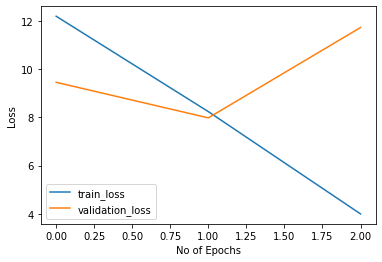

In [29]:
plt.plot(train_losses , label = 'train_loss')
plt.plot(validation_losses , label = 'validation_loss')
plt.xlabel('No of Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Accuracy

In [48]:
def accuracy(loader):
    n_correct = 0
    n_total = 0

    for inputs, targets in loader:
        inputs, targets = inputs.to(device), targets.to(device)

        outputs = model(inputs)

        _, predictions = torch.max(outputs, 1)

        n_correct += (predictions == targets).sum().item()
        n_total += targets.shape[0]

    acc = n_correct / n_total
    return acc *200

In [49]:
train_acc = accuracy(train_loader)


In [50]:
test_acc = accuracy(test_loader)

In [51]:
validation_acc = accuracy(validation_loader)

In [52]:
print(
    f"Train Accuracy : {train_acc}\nTest Accuracy : {test_acc}\nValidation Accuracy : {validation_acc}"
)

Train Accuracy : 13.861386138613863
Test Accuracy : 3.9215686274509802
Validation Accuracy : 9.195402298850574


In [53]:
transform_index_to_disease = dataset.class_to_idx

In [54]:
transform_index_to_disease = dict(
    [(value, key) for key, value in transform_index_to_disease.items()]
)  # reverse the index

In [55]:
data = pd.read_csv("../Project/disease_info.csv", encoding="cp1252")

In [56]:
from PIL import Image
import torchvision.transforms.functional as TF

In [64]:
def single_prediction(image_path):
    image = Image.open(image_path)
    image = image.resize((224, 224))
    input_data = TF.to_tensor(image)
    input_data = input_data.view((-1, 3, 224, 224))
    output = model(input_data)
    output = output.detach().numpy()
    index = np.argmax(output)
    pred_csv = data["disease_name"][index]
    print(pred_csv)
    disease_probability = output[0][1]  # Assuming diseased class is at index 1
    threshold = 0.8  # Adjust the threshold as needed
    if disease_probability < threshold:
        print("The leaf is diseased.")
    else:
        print("The leaf is not diseased.")

In [65]:
single_prediction("../Project/test_images/Apple_ceder_apple_rust.JPG")

Apple : Cedar rust
The leaf is diseased.


In [66]:
#wrong prediction
single_prediction("../Project/test_images/Apple_scab.JPG")

Tomato : Septoria Leaf Spot
The leaf is not diseased.


In [67]:
single_prediction("../Project/test_images/Grape_esca.JPG")

Grape : Esca | Black Measles
The leaf is diseased.


In [68]:
single_prediction("../Project/test_images/apple_black_rot.JPG")

Pepper bell : Healthy
The leaf is not diseased.


In [69]:
single_prediction("../Project/test_images/apple_healthy.JPG")

Apple : Healthy
The leaf is diseased.


In [70]:
single_prediction("../Project/test_images/background_without_leaves.jpg")

Background Without Leaves
The leaf is diseased.


In [71]:
single_prediction("../Project/test_images/blueberry_healthy.JPG")

Blueberry : Healthy
The leaf is diseased.


In [72]:
single_prediction("../Project/test_images/cherry_healthy.JPG")

Cherry : Healthy
The leaf is not diseased.


In [73]:
single_prediction("../Project/test_images/cherry_powdery_mildew.JPG")

Cherry : Powdery Mildew
The leaf is diseased.


In [74]:
single_prediction("../Project/test_images/corn_cercospora_leaf.JPG")

Corn : Cercospora Leaf Spot | Gray Leaf Spot
The leaf is diseased.


In [75]:
single_prediction("../Project/test_images/corn_common_rust.JPG")

Corn : Common Rust
The leaf is diseased.


In [76]:
single_prediction("../Project/test_images/corn_healthy.jpg")

Corn : Healthy
The leaf is diseased.


In [77]:
single_prediction("../Project/test_images/corn_northen_leaf_blight.JPG")

Corn : Northern Leaf Blight
The leaf is diseased.


In [78]:
single_prediction("../Project/test_images/grape_black_rot.JPG")

Grape : Black Rot
The leaf is diseased.


In [79]:
single_prediction("../Project/test_images/grape_healthy.JPG")

Grape : Healthy
The leaf is diseased.


In [80]:
single_prediction("../Project/test_images/grape_leaf_blight.JPG")

Grape : Leaf Blight | Isariopsis Leaf Spot
The leaf is diseased.


In [81]:
single_prediction("../Project/test_images/orange_haunglongbing.JPG")

Orange : Haunglongbing | Citrus Greening
The leaf is diseased.


In [82]:
single_prediction("../Project/test_images/peach_bacterial_spot.JPG")

Peach : Bacterial Spot
The leaf is diseased.


In [83]:
single_prediction("../Project/test_images/peach_healthy.JPG")

Peach : Healthy
The leaf is not diseased.


In [84]:
single_prediction("../Project/test_images/pepper_bacterial_spot.JPG")

Pepper bell : Healthy
The leaf is diseased.


In [85]:
single_prediction("../Project/test_images/pepper_bell_healthy.JPG")

Pepper bell : Healthy
The leaf is not diseased.


In [86]:
single_prediction("../Project/test_images/potato_early_blight.JPG")

Potato : Early Blight
The leaf is diseased.


In [87]:
single_prediction("../Project/test_images/potato_healthy.JPG")

Potato : Healthy
The leaf is diseased.


In [88]:
single_prediction("../Project/test_images/potato_late_blight.JPG")

Potato : Late Blight
The leaf is diseased.


In [89]:
single_prediction("../Project/test_images/raspberry_healthy.JPG")

Raspberry : Healthy
The leaf is diseased.


In [90]:
single_prediction("../Project/test_images/soyaben healthy.JPG")

Soybean : Healthy
The leaf is diseased.


In [91]:
single_prediction("../Project/test_images/potato_late_blight.JPG")

Potato : Late Blight
The leaf is diseased.


In [92]:
single_prediction("../Project/test_images/squash_powdery_mildew.JPG")

Squash : Powdery Mildew
The leaf is diseased.


In [93]:
single_prediction("../Project/test_images/starwberry_healthy.JPG")

Strawberry : Healthy
The leaf is diseased.


In [94]:
single_prediction("../Project/test_images/starwberry_leaf_scorch.JPG")

Strawberry : Leaf Scorch
The leaf is diseased.


In [95]:
single_prediction("../Project/test_images/tomato_bacterial_spot.JPG")

Tomato : Early Blight
The leaf is diseased.


In [96]:
single_prediction("../Project/test_images/tomato_early_blight.JPG")

Tomato : Early Blight
The leaf is diseased.


In [97]:
single_prediction("../Project/test_images/tomato_healthy.JPG")

Tomato : Healthy
The leaf is diseased.


In [98]:
single_prediction("../Project/test_images/tomato_late_blight.JPG")

Tomato : Late Blight
The leaf is diseased.


In [99]:
single_prediction("../Project/test_images/tomato_leaf_mold.JPG")

Tomato : Leaf Mold
The leaf is diseased.


In [100]:
single_prediction("../Project/test_images/tomato_mosaic_virus.JPG")

Tomato : Mosaic Virus
The leaf is diseased.


In [101]:
single_prediction("../Project/test_images/tomato_septoria_leaf_spot.JPG")

Tomato : Septoria Leaf Spot
The leaf is diseased.


In [102]:
single_prediction("../Project/test_images/tomato_spider_mites_two_spotted_spider_mites.JPG")

Tomato : Spider Mites | Two-Spotted Spider Mite
The leaf is diseased.


In [103]:
single_prediction("../Project/test_images/tomato_target_spot.JPG")

Tomato : Target Spot
The leaf is diseased.


In [104]:
single_prediction("../Project/test_images/tomato_yellow_leaf_curl_virus.JPG")

Tomato : Yellow Leaf Curl Virus
The leaf is diseased.
